In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from glob import glob
from PIL import Image
import cv2
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
df = pd.read_csv('/Users/binit/PycharmProjects/FinalProject/Project_File/data/HAM10000_metadata.csv')
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [29]:
#Creating dictionary for displaying more human-friendly labels.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '/Users/binit/PycharmProjects/FinalProject/Project_File/data'

In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)

In [30]:
df['dataset'].value_counts()

dataset
vidir_molemax    3954
vidir_modern     3363
rosendahl        2259
vienna_dias       439
Name: count, dtype: int64

In [31]:
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [32]:
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,cell_type_idx
6894,HAM_0006397,ISIC_0029894,nv,histo,70.0,male,back,vidir_modern,Melanocytic nevi,4
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,rosendahl,Actinic keratoses,0
1766,HAM_0006556,ISIC_0027402,mel,histo,60.0,male,lower extremity,vidir_modern,Melanoma,5
3969,HAM_0004726,ISIC_0027579,nv,follow_up,45.0,female,abdomen,vidir_molemax,Melanocytic nevi,4
3928,HAM_0005253,ISIC_0026715,nv,follow_up,55.0,female,lower extremity,vidir_molemax,Melanocytic nevi,4


In [33]:
df['dataset'].value_counts() ## We have some unknown values in localization 

dataset
vidir_molemax    3954
vidir_modern     3363
rosendahl        2259
vienna_dias       439
Name: count, dtype: int64

In [17]:
df['cell_type'].value_counts() ##highly imbalanced dataset

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

In [34]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
cell_type         0
cell_type_idx     0
dtype: int64

In [14]:
df['image'].map(lambda x: x.shape).value_counts()

KeyError: 'image'

# EDA

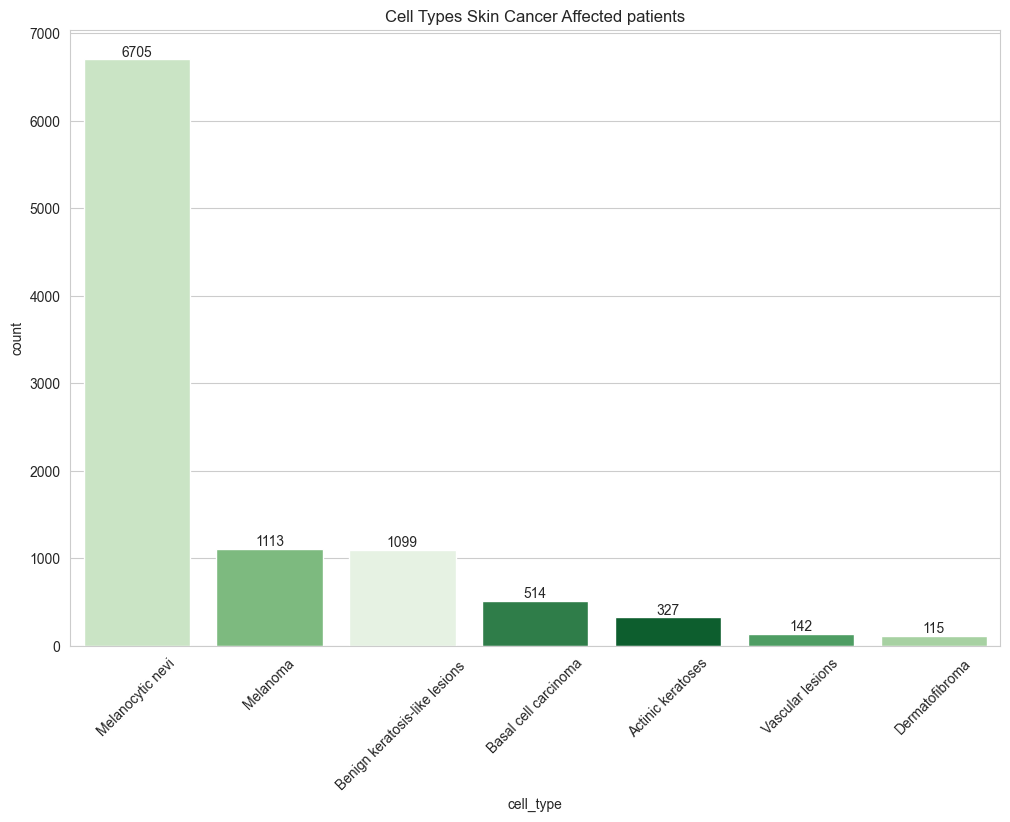

In [36]:
sns.set_palette("Greens")
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette='Greens',
                   hue='cell_type')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

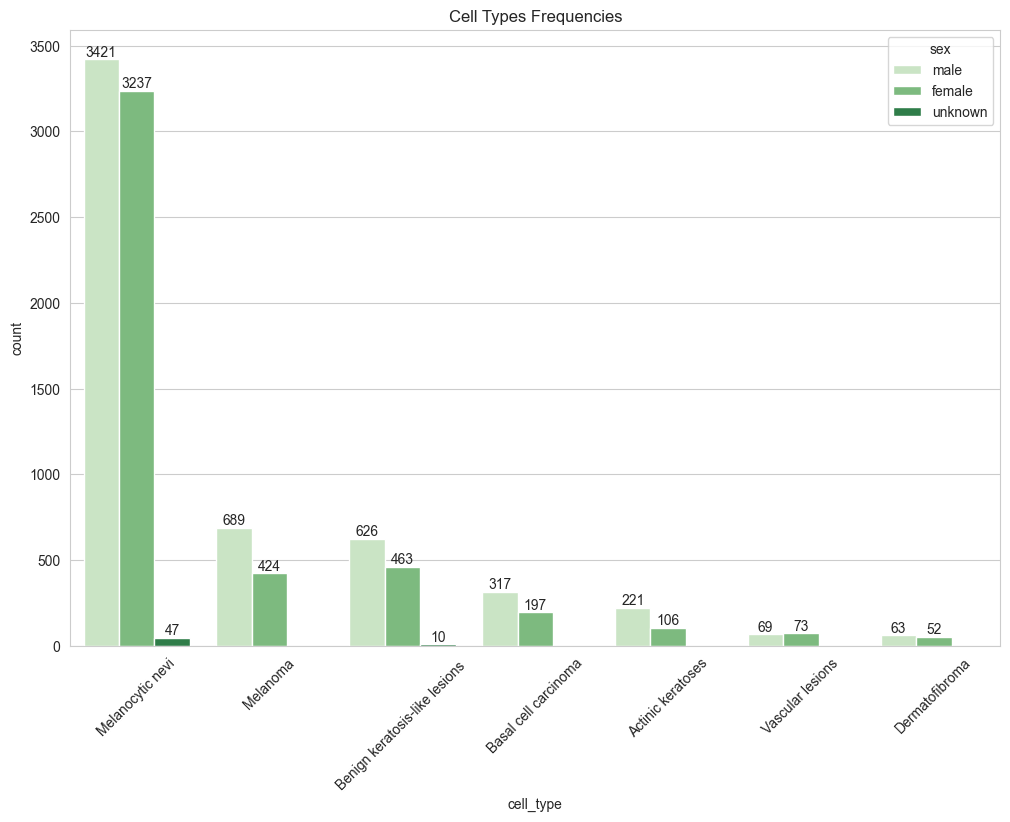

In [47]:
sns.set_palette("Greens")  # Uses built-in 'Greens' colormap
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Greens')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

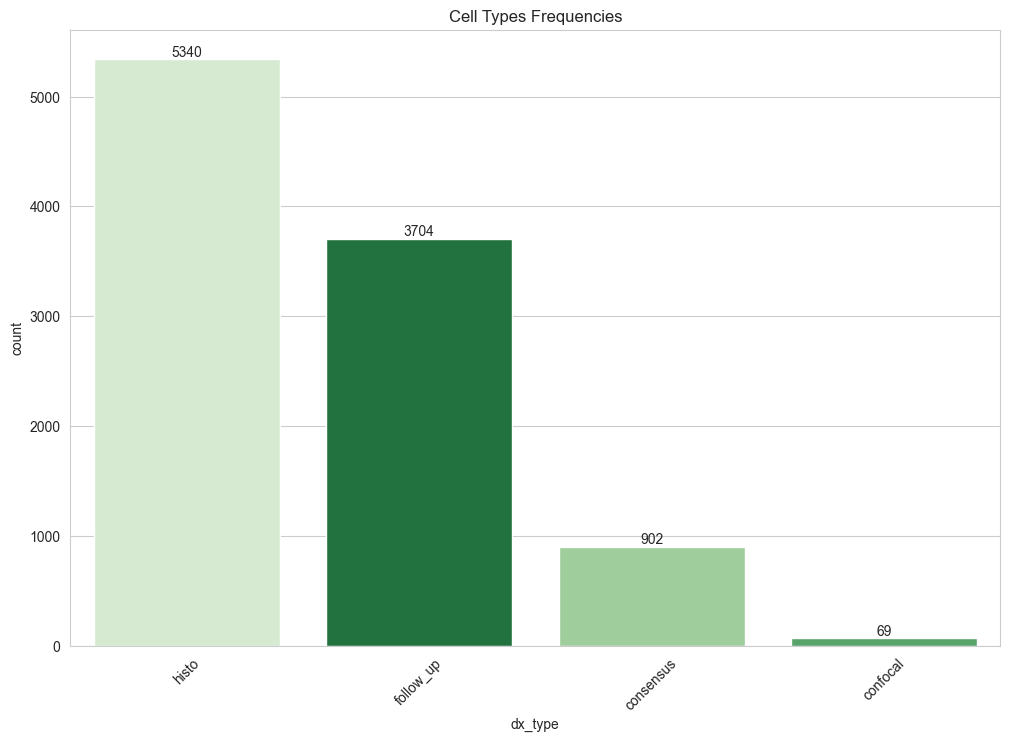

In [43]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'Greens',
                   hue='dx_type')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

**Localization**

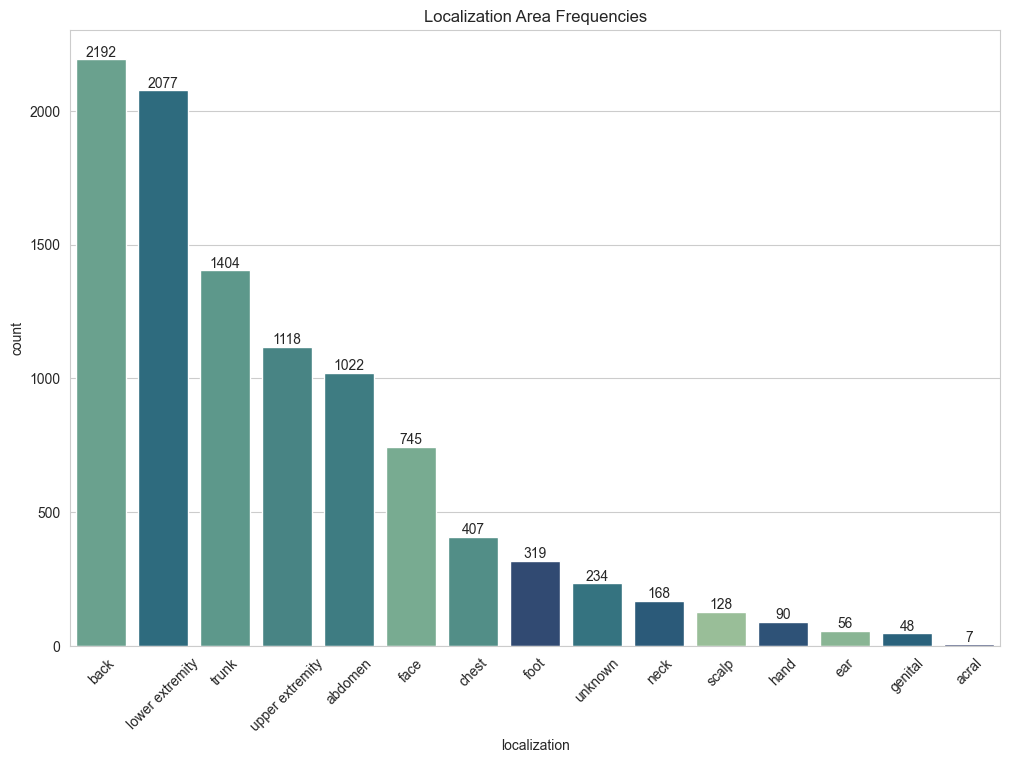

In [45]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest', hue='localization')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

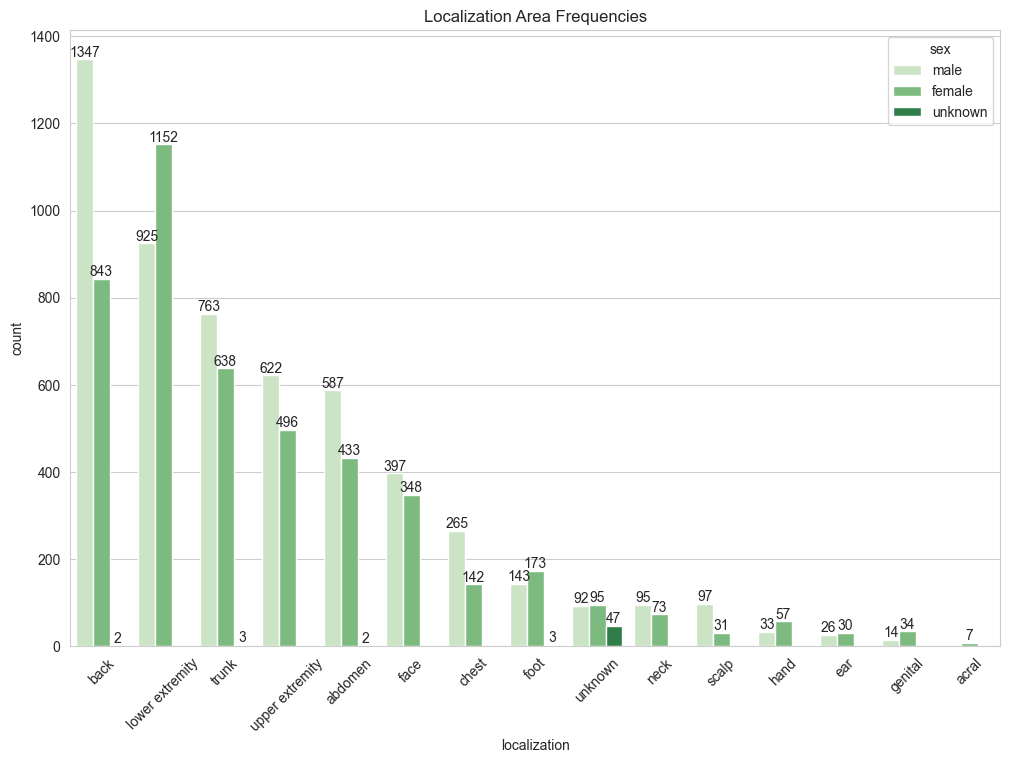

In [49]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',hue='sex', data=df, order = df['localization'].value_counts().index, palette = 'Greens')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

**Age**

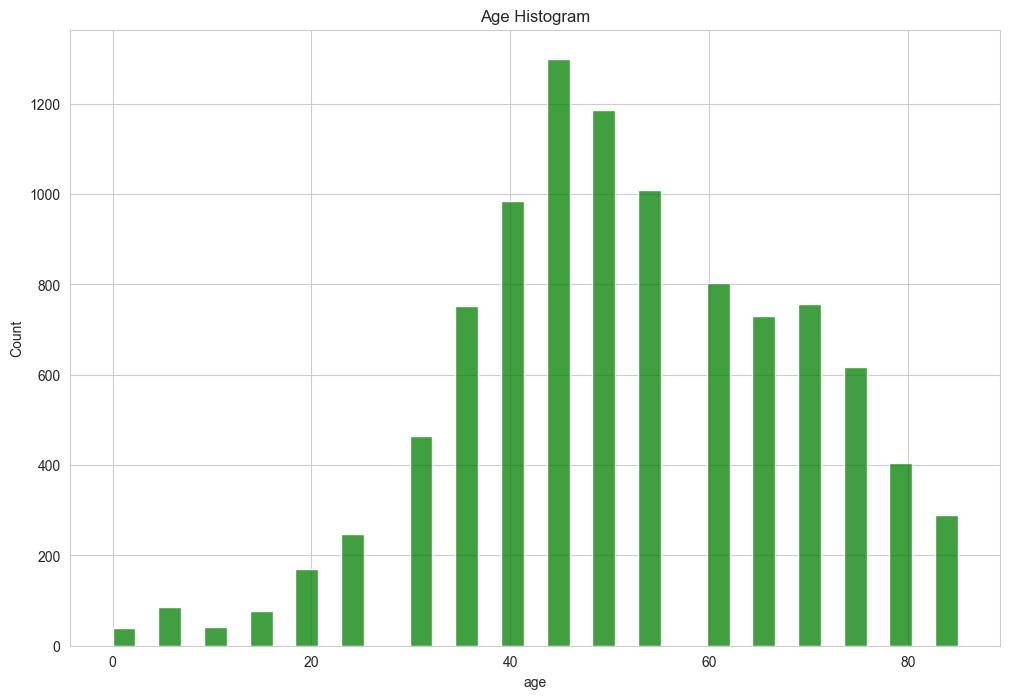

In [52]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age', color='green')
plt.title('Age Histogram')
plt.show()


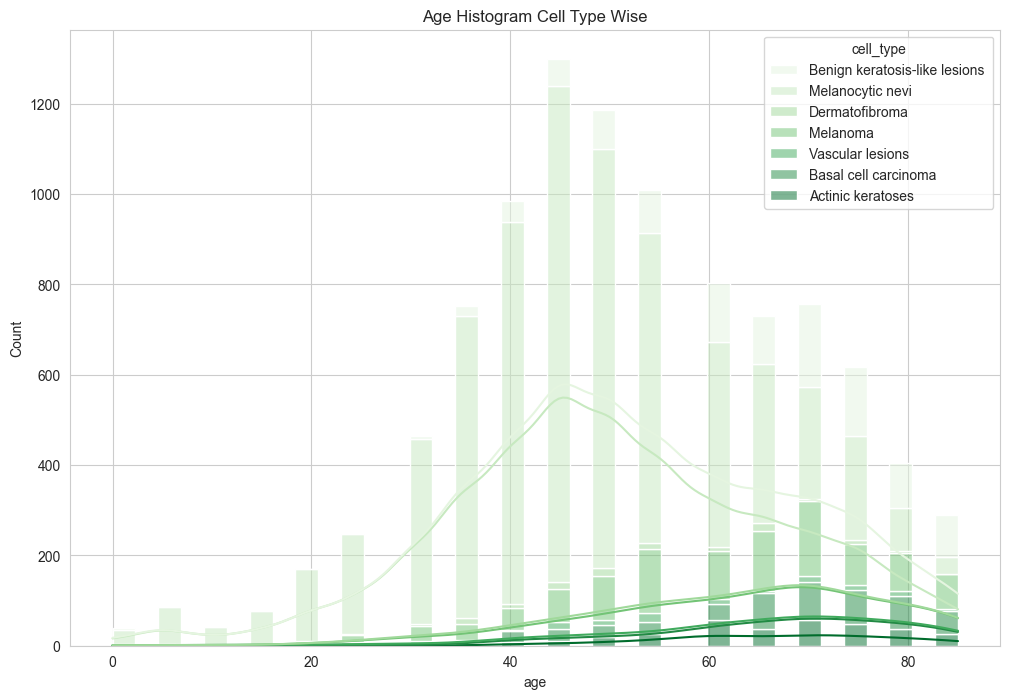

In [57]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack', palette='Greens', kde=True)
plt.title('Age Histogram Cell Type Wise')
plt.show()

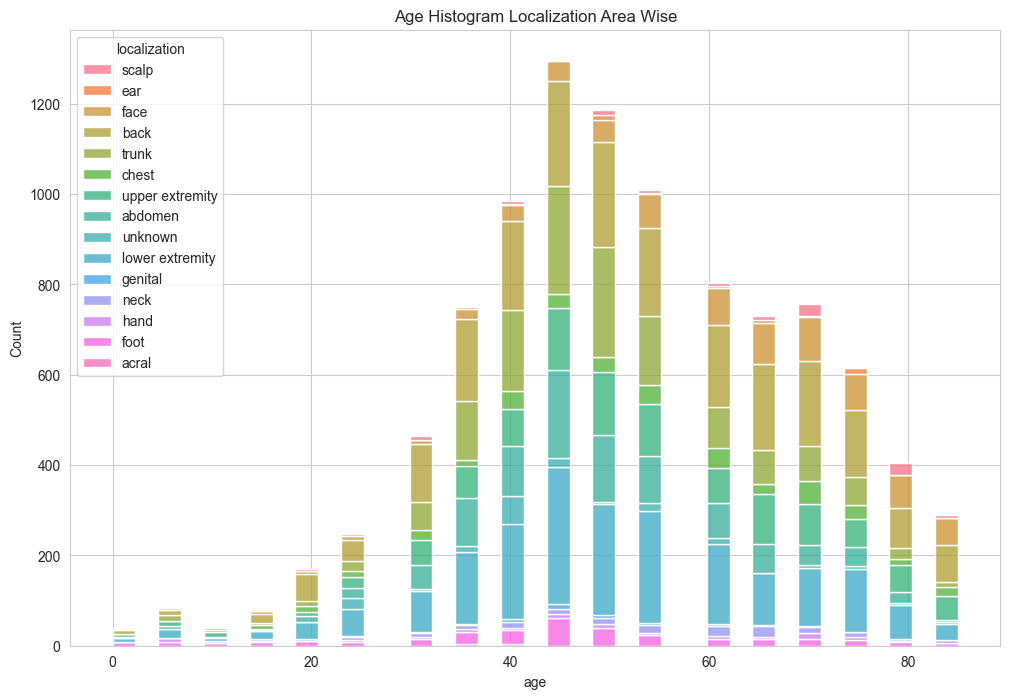

In [70]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

In [19]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis-like lesions,2


In [14]:
sample_image_path = df['path'].iloc[15]
img = Image.open(sample_image_path)

# Display image shape
print(f"Image shape: {img.size}")  # Output (width, height)

img.show()

Image shape: (600, 450)


In [75]:
df['cell_type'].value_counts()

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

In [35]:
df[df['cell_type']=='Melanocytic nevi']

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,cell_type_idx
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face,vidir_modern,Melanocytic nevi,4
1210,HAM_0000559,ISIC_0024693,nv,follow_up,45.0,female,upper extremity,vidir_molemax,Melanocytic nevi,4
2976,HAM_0004932,ISIC_0032212,nv,follow_up,45.0,female,foot,vidir_molemax,Melanocytic nevi,4
2977,HAM_0004516,ISIC_0025775,nv,follow_up,45.0,female,neck,vidir_molemax,Melanocytic nevi,4
2978,HAM_0006510,ISIC_0029828,nv,follow_up,55.0,female,lower extremity,vidir_molemax,Melanocytic nevi,4
...,...,...,...,...,...,...,...,...,...,...
9682,HAM_0006283,ISIC_0027924,nv,consensus,20.0,male,chest,vidir_modern,Melanocytic nevi,4
9683,HAM_0000102,ISIC_0031547,nv,consensus,20.0,male,back,vidir_modern,Melanocytic nevi,4
9684,HAM_0000102,ISIC_0032221,nv,consensus,20.0,male,back,vidir_modern,Melanocytic nevi,4
9685,HAM_0005314,ISIC_0030693,nv,consensus,40.0,male,neck,vidir_modern,Melanocytic nevi,4


In [36]:
drop_column = ['dx', 'image_id','lesion_id','cell_type']
df.drop(columns=drop_column, inplace=True)

In [37]:
df.head(5)

,dx_type,age,sex,localization,dataset,cell_type_idx
0,histo,80.0,male,scalp,vidir_modern,2
1,histo,80.0,male,scalp,vidir_modern,2
2,histo,80.0,male,scalp,vidir_modern,2
3,histo,80.0,male,scalp,vidir_modern,2
4,histo,75.0,male,ear,vidir_modern,2


In [41]:
X, y = df.drop(columns=['cell_type_idx']), df['cell_type_idx']

In [ ]:
# Splitting data
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y test_size=0.2, random_state=42, stratify=df['cell_type_idx'])

In [42]:
categorical_cols = ["dx_type", "sex", "localization", "dataset"]
numeric_cols = ["age"]

# Creating Synthetic data for Minority Class

In [16]:
df1 = df.copy()

In [17]:
df1.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/Users/binit/PycharmProjects/FinalProject/Proj...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/Users/binit/PycharmProjects/FinalProject/Proj...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/Users/binit/PycharmProjects/FinalProject/Proj...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/Users/binit/PycharmProjects/FinalProject/Proj...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/Users/binit/PycharmProjects/FinalProject/Proj...,Benign keratosis-like lesions,2


<Axes: xlabel='cell_type_idx'>

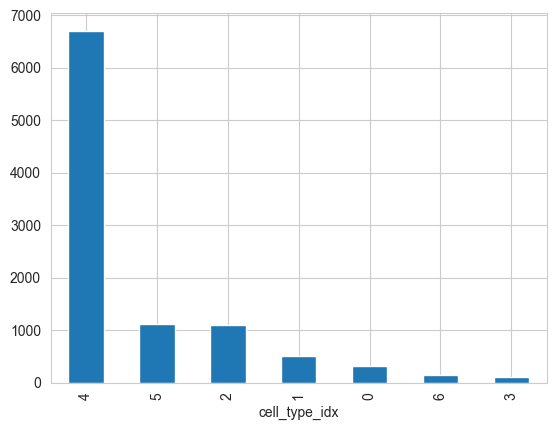

In [18]:
df1['cell_type_idx'].value_counts().plot(kind='bar')

In [19]:
df1.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset', 'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

In [20]:
df1.drop(columns=['lesion_id','dx', 'dx_type', 'age', 'sex', 'localization', 'dataset','cell_type'], inplace=True)

In [21]:
df1.head(5)

,image_id,path,cell_type_idx
0,ISIC_0027419,/Users/binit/PycharmProjects/FinalProject/Proj...,2
1,ISIC_0025030,/Users/binit/PycharmProjects/FinalProject/Proj...,2
2,ISIC_0026769,/Users/binit/PycharmProjects/FinalProject/Proj...,2
3,ISIC_0025661,/Users/binit/PycharmProjects/FinalProject/Proj...,2
4,ISIC_0031633,/Users/binit/PycharmProjects/FinalProject/Proj...,2


In [22]:
# 1) Define your random augment transform with ranges for random ops
augment_transform = transforms.Compose([
    # Random rotation in the range [-30°, +30°]
    transforms.RandomRotation(degrees=(-30, 30)),
    
    # Random color jitter with variable brightness, contrast, saturation, hue
    transforms.ColorJitter(
        brightness=(0.8, 1.2),    # randomly pick brightness factor in [0.8, 1.2]
        contrast=(0.8, 1.2),      # randomly pick contrast factor in [0.8, 1.2]
        saturation=(0.8, 1.2),    # randomly pick saturation factor in [0.8, 1.2]
        hue=(-0.02, 0.02)         # randomly pick hue shift in [-0.02, +0.02]
    ),
    
    # 50% chance of horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Convert PIL image to tensor (C, H, W) in [0,1]
    transforms.ToTensor()
])

def create_augmented_copies(
    df, 
    class_col='cell_type', 
    path_col='path', 
    minority_classes=None, 
    target_count=4000, 
    output_root='augmented_data'
):
    """
    For each class in minority_classes, generate enough augmented images 
    so that the total number of images for that class reaches target_count.
    
    Args:
        df (pd.DataFrame): Original dataframe with columns for class and image path.
        class_col (str): Column name in df representing the class label.
        path_col (str): Column name in df representing the image path.
        minority_classes (list): Classes that need augmentation. 
        target_count (int): Desired total number of images for each minority class.
        output_root (str): Directory where augmented images will be saved.
    
    Returns:
        df_aug (pd.DataFrame): DataFrame containing paths and class labels 
                               for newly generated augmented images.
    """
    if minority_classes is None:
        # Identify minority classes by threshold if not provided
        class_counts = df[class_col].value_counts()
        # e.g., pick classes with < 2000 samples
        minority_classes = class_counts[class_counts < 2000].index.tolist()
    
    # This will store info about newly generated images
    aug_records = []

    # Ensure output root exists
    os.makedirs(output_root, exist_ok=True)

    for cls in minority_classes:
        # Filter df for this class
        df_cls = df[df[class_col] == cls]
        current_count = len(df_cls)
        if current_count >= target_count:
            print(f"Class '{cls}' already has {current_count} images, skipping augmentation.")
            continue
        
        # Number of new images we need to create
        num_needed = target_count - current_count
        # We'll distribute this across the existing images
        # e.g., if current_count=100, and num_needed=2900, then ~29 augmentations per image
        augment_per_image = max(1, num_needed // current_count)

        print(f"Augmenting class '{cls}' from {current_count} to ~{target_count} images. "
              f"~{augment_per_image} copies per original image.")
        
        # Create a subfolder for this class
        class_dir = os.path.join(output_root, str(cls))
        os.makedirs(class_dir, exist_ok=True)

        # Loop through each image in df_cls
        for idx, row in df_cls.iterrows():
            image_path = row[path_col]
            label = row[class_col]

            # Load the image once
            try:
                original = Image.open(image_path).convert("RGB")
            except Exception as e:
                print(f"Warning: could not open image {image_path}, skipping. Error: {e}")
                continue
            
            # Generate multiple augmentations
            for i in range(augment_per_image):
                # Each call to augment_transform picks new random parameters
                augmented_tensor = augment_transform(original)
                
                # Convert to NumPy for saving
                augmented_np = (augmented_tensor.permute(1,2,0).numpy() * 255).astype(np.uint8)
                
                # Save the augmented image
                aug_filename = f"aug_{os.path.basename(image_path).split('.')[0]}_{idx}_{i}.jpg"
                save_path = os.path.join(class_dir, aug_filename)
                
                # Use cv2 to save (convert RGB->BGR)
                cv2.imwrite(save_path, cv2.cvtColor(augmented_np, cv2.COLOR_RGB2BGR))
                
                # Record in aug_records
                aug_records.append({
                    path_col: save_path,
                    class_col: label
                })
            
            # Optional: break if we've reached or exceeded the target
            # but typically we rely on augment_per_image distribution.

    # Create a new DataFrame for the augmented images
    df_aug = pd.DataFrame(aug_records)
    print(f"Total new augmented images: {len(df_aug)}")
    return df_aug

# Example usage:
# Suppose your original df has columns: ['path', 'cell_type', ...]
# and you identified that classes [1,2,3,5,6] are minority.
output_root = "/Users/binit/PycharmProjects/FinalProject/Project_File/data/augmented_data"

minority_classes = [0,1,2,3,5,6]
df_aug = create_augmented_copies(
    df=df, 
    class_col='cell_type_idx',
    path_col='path',
    minority_classes=minority_classes,
    target_count=4000, 
    output_root= output_root
)

# Combine df_aug with df
df_balanced = pd.concat([df1, df_aug], ignore_index=True)

# Now df_balanced physically has more samples for minority classes 
# because df_aug references newly saved images on disk.

Augmenting class '0' from 327 to ~4000 images. ~11 copies per original image.
Augmenting class '1' from 514 to ~4000 images. ~6 copies per original image.
Augmenting class '2' from 1099 to ~4000 images. ~2 copies per original image.
Augmenting class '3' from 115 to ~4000 images. ~33 copies per original image.
Augmenting class '5' from 1113 to ~4000 images. ~2 copies per original image.
Augmenting class '6' from 142 to ~4000 images. ~27 copies per original image.
Total new augmented images: 18734


In [23]:
df_balanced.drop(columns=['image_id'], inplace=True)

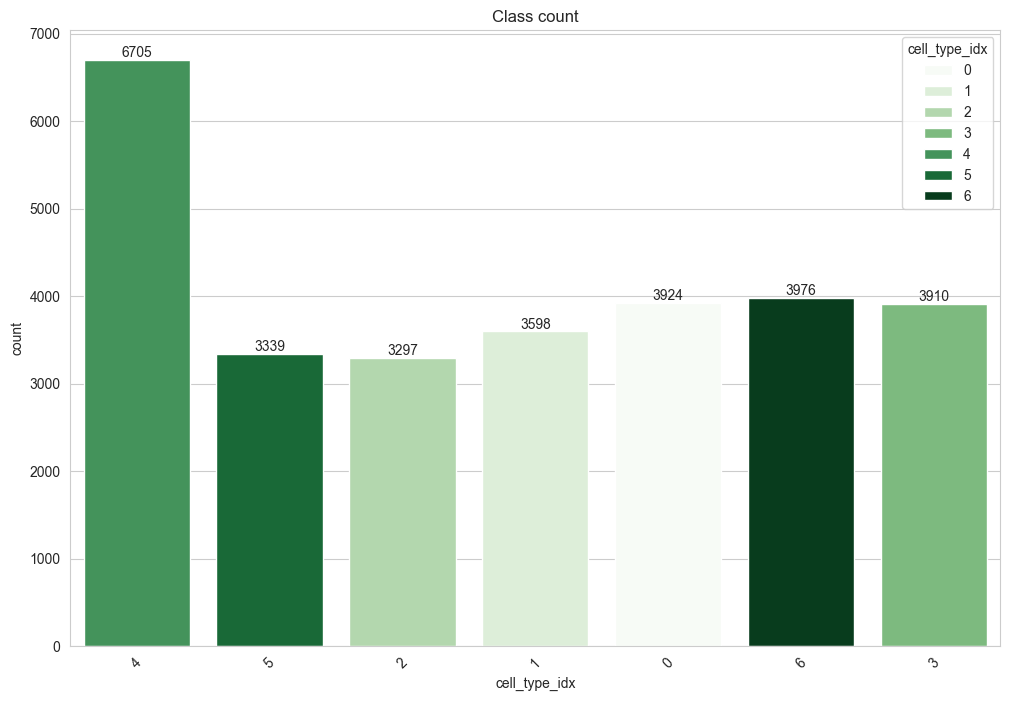

In [24]:
sns.set_palette("Greens")
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type_idx',data=df_balanced, order = df['cell_type_idx'].value_counts().index, palette='Greens',
                   hue='cell_type_idx')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Class count')
plt.xticks(rotation=45)
plt.show()

In [25]:
df_balanced.to_pickle('df_balanced.pkl')